In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from glob import glob

In [2]:
tf.__version__

'2.11.0'

In [3]:
tfio.__version__

'0.31.0'

In [4]:
CAPUCHIN_FILE = 'data/Parsed_Capuchinbird_Clips/XC3776-3.wav'
# CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-4.wav')
NOT_CAPUCHIN_FILE = 'data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav'
# NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-2.wav')


In [5]:
CAPUCHIN_FILE

'data/Parsed_Capuchinbird_Clips/XC3776-3.wav'

In [6]:
#  Build Dataloading Function
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [7]:
# file_contents = tf.io.read_file(CAPUCHIN_FILE)
# wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
# wav

In [8]:
#Plot Wave
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

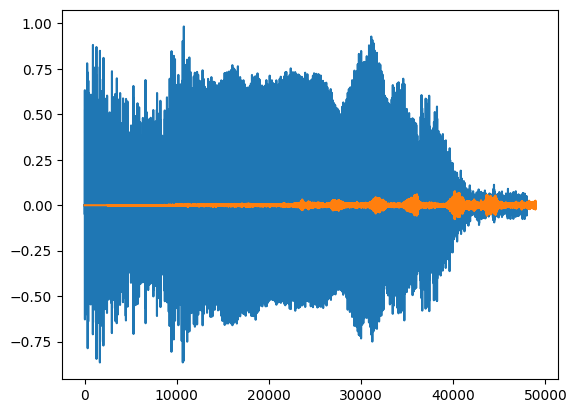

In [9]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [10]:
#Define Paths to Positive and Negative Data
POS = 'drive/MyDrive/data/Parsed_Capuchinbird_Clips'
NEG = 'drive/MyDrive/data/Parsed_Not_Capuchinbird_Clips'

In [11]:
POSi=glob('data/Parsed_Capuchinbird_Clips/*.wav')
NEGi=glob('data/Parsed_Not_Capuchinbird_Clips/*.wav')

In [12]:
# Create Tensorflow Datasets
pos = tf.data.Dataset.list_files(POSi)
neg = tf.data.Dataset.list_files(NEGi)

In [13]:
pos.as_numpy_iterator().next()

b'data\\Parsed_Capuchinbird_Clips\\XC16803-1.wav'

In [14]:
len(pos)

217

In [15]:
tf.ones(len(pos))

<tf.Tensor: shape=(217,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [16]:
#Add labels and Combine Positive and Negative Samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [17]:
data.shuffle(1000).as_numpy_iterator().next()

(b'data\\Parsed_Not_Capuchinbird_Clips\\cricket-sounds-for-sleep-46.wav', 0.0)

In [18]:
#  Determine Average Length of a Capuchin Call

In [19]:
#  Calculate Wave Cycle Length

In [20]:
lengths = []

In [21]:
tf.autograph.set_verbosity(0)

In [22]:
for file in os.listdir('data/Parsed_Capuchinbird_Clips'):
    tensor_wave = load_wav_16k_mono(os.path.join('data/Parsed_Capuchinbird_Clips/', file))
    lengths.append(len(tensor_wave))

In [23]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [24]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [25]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [26]:
# Build Preprocessing Function to Convert to Spectrogram

In [27]:
# Build Preprocessing Function

In [28]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    # first 48000 steps from each signal
    wav = wav[:48000]
    # padding done to check if they don't match with full length of the clip
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    # short time fourier_transform
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [29]:
wav = load_wav_16k_mono(CAPUCHIN_FILE)
wav = wav[:48000]
zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
wav = tf.concat([zero_padding, wav],0)

In [30]:
spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
spectrogram = tf.abs(spectrogram)
spectrogram = tf.expand_dims(spectrogram, axis=2)

In [31]:
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[7.2591394e-02],
        [7.1032852e-02],
        [6.9773473e-02],
        ...,
        [4.7592903e-04],
        [2.4586404e-04],
        [7.3611736e-06]],

       [[3.5664439e-03],
        [9.9268171e-04],
        [5.6907088e-03],
        ...,
        [3.8838305e-04],
        [1.9547240e-04],
        [3.3080578e-05]],

       [[3.7607998e-03],
        [2.7487839e-03],
        [3.5495190e-03],
        ...,
        [3.2278040e-04],
        [2.2552285e-04],
        [4.4688582e-05]],

       ...,

       [[5.8630481e-03],
        [8.9062378e-03],
        [1.5015538e-02],
        ...,
        [7.9599919e-04],
        [3.3273522e-04],
        [1.2891740e-04]],

       [[3.7055314e-03],
        [6.7680865e-03],
        [1.3490748e-02],
        ...,
        [7.4697129e-04],
        [4.1957214e-04],
        [2.7258694e-04]],

       [[6.5301359e-04],
        [3.5431648e-03],
        [1.0943870e-02],
        ...,
        [8.1216783

In [32]:
#Test Out the Function and Viz the Spectrogram
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [33]:
spectrogram, label = preprocess(filepath, label)

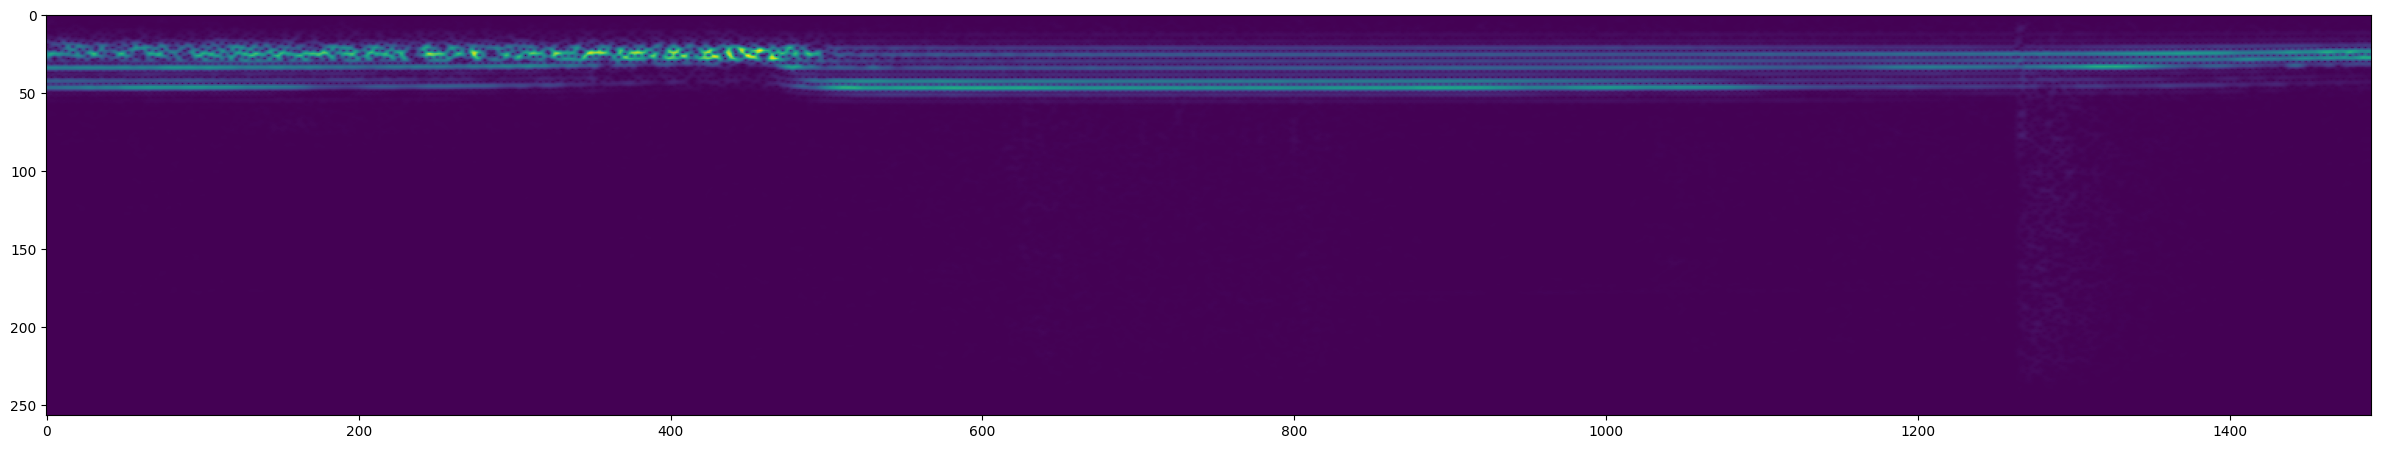

In [34]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

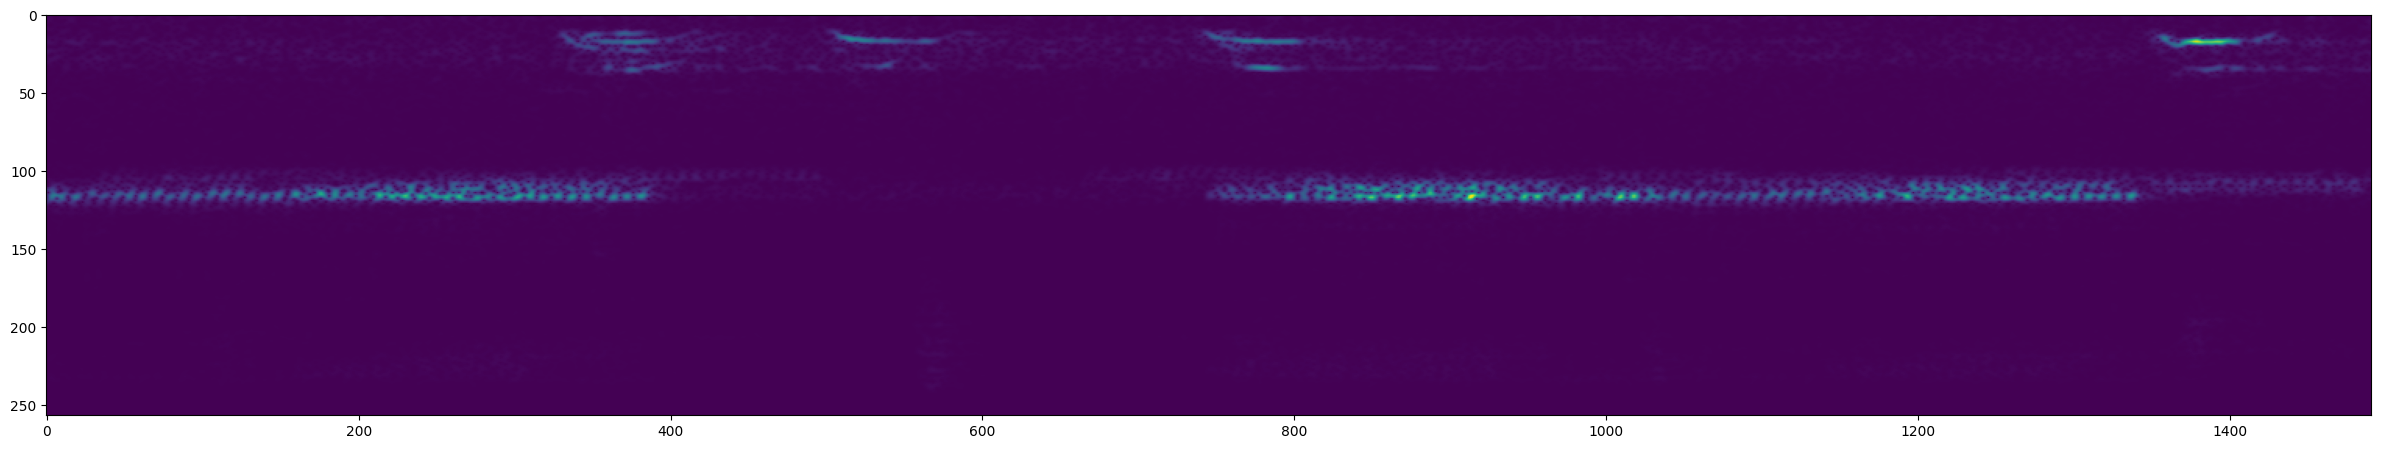

In [35]:
filepath, label = negatives.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [36]:
#Create Training and Testing Partitions

In [37]:
# Create a Tensorflow Data Pipeline
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [38]:
#Split into Training and Testing Partitions
train = data.take(36)
test = data.skip(36).take(15)

In [39]:
#Test One Batch
samples, labels = train.as_numpy_iterator().next()

In [40]:
samples.shape

(16, 1491, 257, 1)

In [41]:
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [42]:
# Build Deep Learning Model

In [43]:
# # Tensorflow Dependencies
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [44]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten

In [45]:
# Build Sequential Model, Compile and View Summary
model = Sequential()
# 16 kernel of shape 3 x 3
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [46]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 32)                192620064 
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 192,622,577
Trainable params: 192,622,577
Non-trainable params: 0
_________________________________________________________________


In [48]:
#Fit Model, View Loss and KPI Plots

In [49]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 235s 6s/step - loss: 1.1021 - recall: 0.8725 - precision: 0.8553 - val_loss: 0.0577 - val_recall: 0.9841 - val_precision: 1.0000
Epoch 2/4
36/36 [==============================] - 227s 6s/step - loss: 0.0324 - recall: 0.9671 - precision: 0.9932 - val_loss: 0.0034 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 229s 6s/step - loss: 0.0146 - recall: 0.9872 - precision: 1.0000 - val_loss: 0.0033 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 238s 7s/step - loss: 0.0023 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.9225e-04 - val_recall: 1.0000 - val_precision: 1.0000


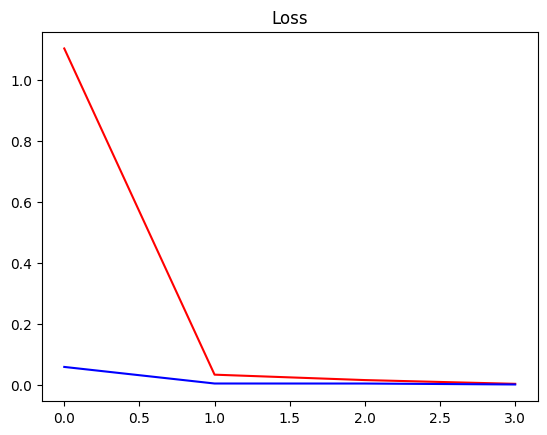

In [50]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

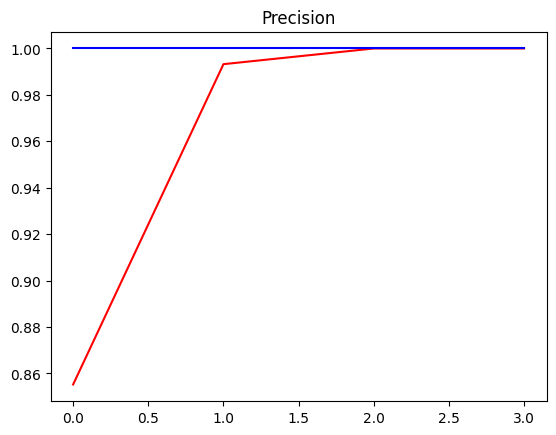

In [51]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

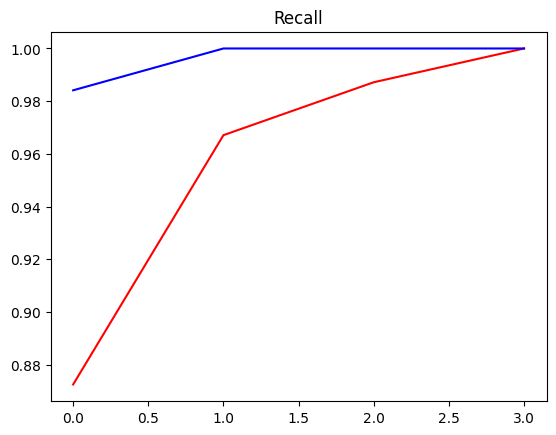

In [52]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [53]:
#Make a Prediction on a Single Clip

In [54]:
#Get One Batch and Make a Prediction

In [55]:
X_test, y_test = test.as_numpy_iterator().next()

In [56]:
X_test.shape

(16, 1491, 257, 1)

In [57]:
yhat = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [58]:
import pickle

In [59]:
pickle.dump(model,open('mymodel.pkl','wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\flatten
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\precision
......vars
.........0
.........1
...metrics\recall
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2024-05-10 00:03:57         3033
metadata.json                                  2024-05-10 00:03:57           64
variables.h5                                   2024-05-

In [60]:
pickled_model=pickle.load(open('mymodel.pkl','rb'))

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2024-05-10 00:03:56         3033
metadata.json                                  2024-05-10 00:03:56           64
variables.h5                                   2024-05-10 00:04:28   2311502416
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\flatten
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\precision
......vars
.........0
.........1
...metrics\recall
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
....

In [61]:
pickled_model.predict(X_test)

1/1 [==============================] - 2s 2s/step


array([[1.0000000e+00],
       [4.9600230e-06],
       [9.9999171e-01],
       [1.5735661e-26],
       [1.0000000e+00],
       [8.6287673e-06],
       [4.8037826e-05],
       [7.7819290e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.8017290e-07],
       [1.6157013e-04],
       [4.6423033e-06],
       [1.0287218e-05],
       [3.5331744e-09]], dtype=float32)

In [62]:
yhat

array([[1.0000000e+00],
       [4.9600230e-06],
       [9.9999171e-01],
       [1.5735661e-26],
       [1.0000000e+00],
       [8.6287673e-06],
       [4.8037826e-05],
       [7.7819290e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.8017290e-07],
       [1.6157013e-04],
       [4.6423033e-06],
       [1.0287218e-05],
       [3.5331744e-09]], dtype=float32)

In [63]:
#Convert Logits to Classes
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [64]:
yhat

[1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]

In [65]:
y_test

array([1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [66]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [67]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

In [68]:
#Build Forest Parsing Functions

In [69]:
# Load up MP3s

In [70]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [71]:
mp3='data/Forest_Recordings/recording_00.mp3'

In [72]:
wav = load_mp3_16k_mono(mp3)

In [73]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [74]:
samples, index = audio_slices.as_numpy_iterator().next()

In [75]:
samples.shape

(1, 48000)

In [76]:
len(audio_slices)

60

In [77]:
# Build Function to Convert Clips into Windowed Spectrograms

In [78]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [79]:
# Convert Longer Clips into Windows and Make Predictions

In [80]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(32)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
yhat

In [ ]:
#Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

In [ ]:
# Make Predictions

In [ ]:
#Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir('data/Forest_Recordings'):
    FILEPATH = os.path.join('data/Forest_Recordings/', file)    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(16)
    yhat = model.predict(audio_slices)
    results[file] = yhat

In [ ]:
results

In [ ]:
# Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

In [ ]:
#Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed